# BUAN 6341.002 - Applied Machine Learning
# Project 2


## Professor : Nassim Sohaee


### Submitted by :
### Prem Kumar Pulluri


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine import missing_data_imputers as mdi
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
%matplotlib inline

## Classification Part

## Load the dataset

In [2]:
df = pd.read_csv('bank_final_new.csv')

In [3]:
df.y.value_counts()

yes    1716
no     1632
Name: y, dtype: int64

Dataset looks balanced

## Pre-processing

### Check for null values

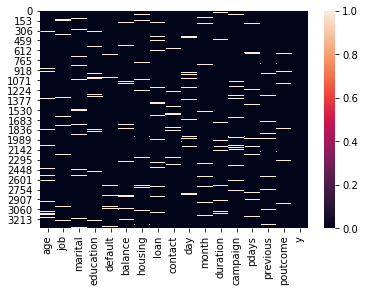

In [4]:
sns.heatmap(df.isnull(),)

### Drop unnecessary columns

In [5]:
df.drop(['day', 'month', 'contact', 'pdays', 'previous', 'poutcome'], axis=1, inplace=True)

### Drop rows where target variable has null values

In [6]:
df.dropna(subset=['y'], inplace=True)

In [7]:
df_og = df.copy()

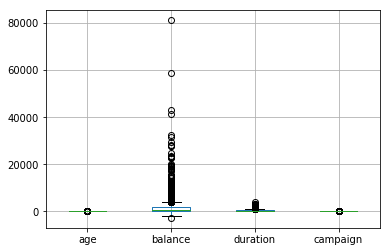

In [8]:
# Checking to see outliers
df.boxplot()

In [9]:
df.y = df.y.map(dict(yes=1, no=0)) # Mapping 'yes' and 'no' to 1 and 0

In [10]:
X = df.drop(['y'], axis=1) # Extracting features from the dataset

In [11]:
y = df[['y']] # Extracting target variable from dataset

### Splitting data into train and test set

In [12]:
X_train_og, X_test_og, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

### Preprocessing pipeline

In [13]:
bank_pipe = Pipeline([

    # missing data imputation pipeline
    ('imputer_num_mean',
     mdi.MeanMedianImputer(imputation_method='mean',variables=['age'])),
    
    ('imputer_num_mean2',
     mdi.MeanMedianImputer(imputation_method='mean',variables=['duration'])),
    
    ('imputer_num_mean3',
     mdi.MeanMedianImputer(imputation_method='mean',variables=['campaign'])),
    
    ('imputer_num_mean4',
     mdi.MeanMedianImputer(imputation_method='mean',variables=['balance'])),
    
    ('imputer_cat_missing',
     mdi.CategoricalVariableImputer(variables=['job','marital', 'education', 'default'
                                              , 'housing', 'loan'])),
    
    # Variables to encode
    ('categorical_encoder',
     OneHotCategoricalEncoder( top_categories=None,
                               variables=['job','marital', 'education', 'default'
                                        , 'housing', 'loan'],
                               drop_last=True)),
    
])

In [14]:
bank_pipe.fit(X_train_og, y_train) # Fitting data to pipeline

Pipeline(memory=None,
     steps=[('imputer_num_mean', MeanMedianImputer(imputation_method='mean', variables=['age'])), ('imputer_num_mean2', MeanMedianImputer(imputation_method='mean', variables=['duration'])), ('imputer_num_mean3', MeanMedianImputer(imputation_method='mean', variables=['campaign'])), ('imputer_num_mean4', M...gories=None,
             variables=['job', 'marital', 'education', 'default', 'housing', 'loan']))])

In [15]:
X_train_imputed = bank_pipe.transform(X_train_og)
X_test_imputed = bank_pipe.transform(X_test_og) # Fetching the pipeline fitted dataset

Discretizing continuous features here

In [16]:
X_train_imputed.age = pd.cut(X_train_imputed.age, bins=10)
X_test_imputed.age = pd.cut(X_test_imputed.age, bins=10) 
# discretizing continuous feature

In [17]:
X_train_imputed.balance = pd.cut(X_train_imputed.balance, bins=5)
X_test_imputed.balance = pd.cut(X_test_imputed.balance, bins=5) 
# discretizing continuous feature

In [18]:
X_train_imputed.duration = pd.cut(X_train_imputed.duration, bins=5)
X_test_imputed.duration = pd.cut(X_test_imputed.duration, bins=5) 
# discretizing continuous feature

In [19]:
X_train_imputed = pd.get_dummies(X_train_imputed, columns=['age', 'balance', 'duration'])
X_test_imputed = pd.get_dummies(X_test_imputed, columns=['age', 'balance', 'duration'])
# Creating dummy variables from dicretized features

In [20]:
# Scaling data using Robust scaler because there are outliers
scaler = RobustScaler()
scaler.fit(X_train_imputed)
X_train = scaler.transform(X_train_imputed)
X_test = scaler.transform(X_test_imputed)

In [21]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [22]:
ensemble_report = pd.DataFrame(index = '0 1 2 3 4 5 6 7 8 9'.split(), columns='ModelName TrainScore TestScore'.split())

## Voting Classifiers

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [24]:
clf1 = LogisticRegression(multi_class='auto', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

### Hard voting

In [25]:
vc1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

In [26]:
vc1.fit(X_train, y_train)

D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFores...andom_state=1, verbose=0, warm_start=False)), ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [27]:
print("Hard voting Classifier Train Performance: ",vc1.score(X_train,y_train))
print("Hard voting Classifier Test Performance: ",vc1.score(X_test,y_test))

Hard voting Classifier Train Performance:  0.795134443021767
Hard voting Classifier Test Performance:  0.663681592039801


In [28]:
ensemble_report['ModelName']['0'] = 'Hard voting Classifier'
ensemble_report['TrainScore']['0'] = vc1.score(X_train,y_train)
ensemble_report['TestScore']['0'] = vc1.score(X_test,y_test)

### Soft voting

In [29]:
vc2 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

In [30]:
vc2.fit(X_train, y_train)

D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFores...andom_state=1, verbose=0, warm_start=False)), ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [31]:
print("Soft voting Classifier Train Performance: ",vc2.score(X_train,y_train))
print("Soft voting Classifier Test Performance: ",vc2.score(X_test,y_test))

Soft voting Classifier Train Performance:  0.7144686299615877
Soft voting Classifier Test Performance:  0.6557213930348259


In [32]:
ensemble_report['ModelName']['1'] = 'Soft voting Classifier'
ensemble_report['TrainScore']['1'] = vc2.score(X_train,y_train)
ensemble_report['TestScore']['1'] = vc2.score(X_test,y_test)

## Bagging

### Bagging with SVC

In [33]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [34]:
from sklearn.svm import SVC
bag_svc1 = BaggingClassifier(base_estimator=SVC(C=10,gamma=0.01,kernel='rbf'), bootstrap=True, random_state=0, oob_score=False)

bag_svc1.fit(X_train, y_train)
#Check test data set performance
print("Support Vector Classifier Train Performance: ",bag_svc1.score(X_train,y_train))
print("Support Vector Classifier Test Performance: ",bag_svc1.score(X_test,y_test))

Support Vector Classifier Train Performance:  0.696969696969697
Support Vector Classifier Test Performance:  0.708457711442786


In [35]:
ensemble_report['ModelName']['2'] = 'SVC Bagging Classifier'
ensemble_report['TrainScore']['2'] = bag_svc1.score(X_train,y_train)
ensemble_report['TestScore']['2'] = bag_svc1.score(X_test,y_test)

### Bagging with Decision tree

In [36]:
bag_dtree1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=True, random_state=0, oob_score=False)

bag_dtree1.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=0, verbose=0, warm_start=False)

In [37]:
print(f'Train score is {bag_dtree1.score(X_train,y_train)}')
print(f'Test score is {bag_dtree1.score(X_test,y_test)}')

Train score is 0.9082373026034998
Test score is 0.6258706467661691


In [38]:
ensemble_report['ModelName']['3'] = 'Decision Tree Bagging Classifier'
ensemble_report['TrainScore']['3'] = bag_dtree1.score(X_train,y_train)
ensemble_report['TestScore']['3'] = bag_dtree1.score(X_test,y_test)

## Pasting

### Pasting with SVC

In [39]:
from sklearn.svm import SVC
paste_svm_grid = BaggingClassifier(base_estimator=SVC(gamma='auto'), bootstrap=False, random_state=0, oob_score=False)

paste_svm_grid.fit(X_train, y_train)

#Check test data set performance
print("Support Vector Classifier Train Performance: ",paste_svm_grid.score(X_train,y_train))
print("Support Vector Classifier Test Performance: ",paste_svm_grid.score(X_test,y_test))
print()

Support Vector Classifier Train Performance:  0.6794707639778063
Support Vector Classifier Test Performance:  0.6955223880597015



In [40]:
ensemble_report['ModelName']['4'] = 'SVC pasting Classifier'
ensemble_report['TrainScore']['4'] = paste_svm_grid.score(X_train,y_train)
ensemble_report['TestScore']['4'] = paste_svm_grid.score(X_test,y_test)

### Pasting with Decision tree

In [41]:
paste_dtree1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap=False, random_state=0, oob_score=False)

paste_dtree1.fit(X_train,y_train)

print(f'Train score is {paste_dtree1.score(X_train,y_train)}')
print(f'Test score is {paste_dtree1.score(X_test,y_test)}')

Train score is 0.9193341869398207
Test score is 0.5980099502487563


In [42]:
ensemble_report['ModelName']['5'] = 'Decision Tree pasting Classifier'
ensemble_report['TrainScore']['5'] = paste_dtree1.score(X_train,y_train)
ensemble_report['TestScore']['5'] = paste_dtree1.score(X_test,y_test)

## Ada boost

### Ada boost Decision tree

In [43]:
from sklearn.ensemble import AdaBoostClassifier
adc_dtree =AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)

adc_dtree.fit(X_train,y_train)

print(f'Train score is {adc_dtree.score(X_train,y_train)}')
print(f'Test score is {adc_dtree.score(X_test,y_test)}')

Train score is 0.9193341869398207
Test score is 0.6159203980099502


In [44]:
ensemble_report['ModelName']['6'] = 'Decision Tree pasting Classifier'
ensemble_report['TrainScore']['6'] = adc_dtree.score(X_train,y_train)
ensemble_report['TestScore']['6'] = adc_dtree.score(X_test,y_test)

### Ada boost with SVC

In [45]:
adc_svc =AdaBoostClassifier(base_estimator=SVC(gamma='auto'),random_state=42, algorithm='SAMME')

adc_svc.fit(X_train,y_train)

print(f'Train score is {adc_svc.score(X_train,y_train)}')
print(f'Test score is {adc_svc.score(X_test,y_test)}')

Train score is 0.5249679897567221
Test score is 0.4835820895522388


In [46]:
ensemble_report['ModelName']['7'] = 'Decision Tree pasting Classifier'
ensemble_report['TrainScore']['7'] = adc_svc.score(X_train,y_train)
ensemble_report['TestScore']['7'] = adc_svc.score(X_test,y_test)

## Gradient boost

In [47]:
from  sklearn.ensemble import GradientBoostingClassifier
gbc= GradientBoostingClassifier(random_state=42)

gbc.fit(X_train,y_train)
print(f'Train score is {gbc.score(X_train,y_train)}')
print(f'Test score is {gbc.score(X_test,y_test)}')

Train score is 0.725138711054204
Test score is 0.6776119402985075


In [48]:
ensemble_report['ModelName']['8'] = 'Gradient boosting Classifier'
ensemble_report['TrainScore']['8'] = gbc.score(X_train,y_train)
ensemble_report['TestScore']['8'] = gbc.score(X_test,y_test)

## Deep learning Model - Classification

In [49]:
from keras.models import Sequential
from keras.layers import Dense
import numpy

Using TensorFlow backend.


In [50]:
model = Sequential()
model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [51]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
model.fit(X_train, y_train, epochs=150, batch_size=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/150
2343/2343 [==============================] - 1s 281us/step - loss: 0.6879 - accuracy: 0.5510
Epoch 2/150
2343/2343 [==============================] - 0s 113us/step - loss: 0.6468 - accuracy: 0.6607
Epoch 3/150
2343/2343 [==============================] - 0s 115us/step - loss: 0.6136 - accuracy: 0.6765
Epoch 4/150
2343/2343 [==============================] - 0s 114us/step - loss: 0.5879 - accuracy: 0.6884
Epoch 5/150
2343/2343 [==============================] - 0s 109us/step - loss: 0.5783 - accuracy: 0.6914
Epoch 6/150
2343/2343 [==============================] - 0s 111us/step - loss: 0.5717 - accuracy: 0.7059
Epoch 7/150
2343/2343 [==============================] - 0s 128us/step - loss: 0.5673 - accuracy: 0.7068
Epoch 8/150
2343/2343 [==============================] - 0s 134us/step - loss: 0.5637 - accuracy: 0.7098
Epoch 9/150
2343/2343 [==============================] - 0s 131us/step - loss: 0.5604 - accuracy: 0.7119
Epoch 1

In [53]:
print(f'Train score is {model.evaluate(X_train, y_train)[1]}')
print(f'Test score is {model.evaluate(X_test, y_test)[1]}')

2343/2343 [==============================] - 0s 52us/step
Train score is 0.7836107611656189
1005/1005 [==============================] - 0s 15us/step
Test score is 0.6278607249259949


In [54]:
ensemble_report['ModelName']['9'] = 'Deep learning Classifier'
ensemble_report['TrainScore']['9'] = model.evaluate(X_train, y_train)[1]
ensemble_report['TestScore']['9'] = model.evaluate(X_test, y_test)[1]

1005/1005 [==============================] - 0s 18us/step


In [56]:
y_predict = model.predict_classes(X_test)
y_predict

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [1]])

## Overview

In [80]:
ensemble_report

,ModelName,TrainScore,TestScore
0,Hard voting Classifier,0.795134,0.663682
1,Soft voting Classifier,0.714469,0.655721
2,SVC Bagging Classifier,0.69697,0.708458
3,Decision Tree Bagging Classifier,0.908237,0.625871
4,SVC pasting Classifier,0.679471,0.695522
5,Decision Tree pasting Classifier,0.919334,0.59801
6,Decision Tree pasting Classifier,0.919334,0.61592
7,Decision Tree pasting Classifier,0.524968,0.483582
8,Gradient boosting Classifier,0.725139,0.677612
9,Deep learning Classifier,0.783611,0.627861


`With this dataset, we get the best accuracy score when we use SVC Bagging Classifier`

## PCA

### Preprocess data for PCA

In [57]:
# Preprocess data for PCA
bank_pipe.fit(X, y)
X_clean = bank_pipe.transform(X)
scaler = RobustScaler()
scaler.fit(X_clean)
X_scaled = scaler.transform(X_clean)

In [58]:
# Get our explained variance ratios from PCA using all features
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_scaled)
exp_variance = pca.explained_variance_ratio_
(exp_variance)

array([4.59310296e-01, 1.54677506e-01, 9.40435605e-02, 6.22684745e-02,
       4.51494179e-02, 3.52690611e-02, 2.32540708e-02, 1.91171632e-02,
       1.70315489e-02, 1.21172612e-02, 1.05433731e-02, 9.81580798e-03,
       9.16291575e-03, 8.29549645e-03, 6.97579360e-03, 5.10286776e-03,
       4.50464077e-03, 4.13963189e-03, 3.38305642e-03, 2.81311403e-03,
       2.52861908e-03, 2.17272568e-03, 2.09020876e-03, 1.85014246e-03,
       1.72978243e-03, 1.23827453e-03, 8.39773961e-04, 5.14563242e-04,
       6.08525721e-05])

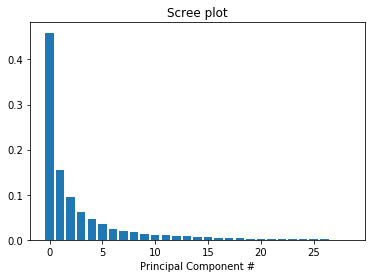

In [59]:
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')
ax.set_title('Scree plot')
plt.show()

In [60]:
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)
cum_exp_variance

array([0.4593103 , 0.6139878 , 0.70803136, 0.77029984, 0.81544925,
       0.85071832, 0.87397239, 0.89308955, 0.9101211 , 0.92223836,
       0.93278173, 0.94259754, 0.95176046, 0.96005595, 0.96703175,
       0.97213461, 0.97663925, 0.98077889, 0.98416194, 0.98697506,
       0.98950368, 0.9916764 , 0.99376661, 0.99561675, 0.99734654,
       0.99858481, 0.99942458, 0.99993915, 1.        ])

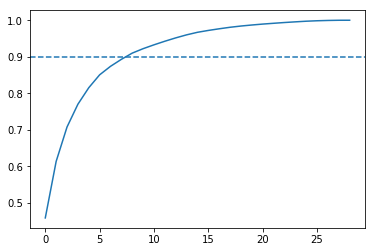

In [61]:
# plotting cumulative explained variance and the threshold at 0.9
fig, ax = plt.subplots()
ax.plot(range(len(cum_exp_variance)),cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
plt.show()

In [62]:
# From the graph we see that the curve is approx. at 5. It's better to take 7 to be sure
n_components = 8
# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(X_scaled)
pca_projection = pca.transform(X_scaled)

In [63]:
# Split the PCA projection into train and test data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_projection,y,test_size=0.3,random_state=0)

In [64]:
y_train_pca = y_train_pca.values.ravel()
y_test_pca = y_test_pca.values.ravel()

In [65]:
class_report = pd.DataFrame(index = '0 1 2 3 4'.split(), columns='ModelName TrainScore TestScore Accuracy CVScore'.split())

### Kernelized SVM with PCA

In [66]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['poly'],
               'degree': [2, 3, 4, 5, 6]}]
svm_grid = GridSearchCV(svc, param_grid, cv=5,return_train_score=True,scoring='accuracy')
svm_grid.fit(X_train_pca, y_train_pca)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(svm_grid.best_score_), end='\n\n')

#find best parameters
print('Kernelized SVM Best parameters: ',svm_grid.best_params_, end='\n\n')

#Check test data set performance
print("Kernelized SVM Train Performance: ",svm_grid.score(X_train_pca,y_train_pca))
print("Kernelized SVM Test Performance: ",svm_grid.score(X_test_pca,y_test_pca), end='\n\n')


prediction = svm_grid.predict(X_test_pca)
print("Accuracy:",metrics.accuracy_score(prediction,y_test_pca))
print("F1 score:",metrics.f1_score(prediction,y_test_pca))
print("Precision:",metrics.precision_score(prediction,y_test_pca))
print("Recall:",metrics.recall_score(prediction,y_test_pca))
print("ROC_AUC:",metrics.roc_auc_score(prediction,y_test_pca))
print("Confusion Matrix:\n",metrics.confusion_matrix(prediction, y_test_pca))

Best Mean Cross-validation score: 0.78

Kernelized SVM Best parameters:  {'C': 1, 'kernel': 'linear'}

Kernelized SVM Train Performance:  0.7767819035424669
Kernelized SVM Test Performance:  0.7562189054726368

Accuracy: 0.7562189054726368
F1 score: 0.7434554973821988
Precision: 0.7304526748971193
Recall: 0.7569296375266524
ROC_AUC: 0.7562633262260127
Confusion Matrix:
 [[405 131]
 [114 355]]


In [67]:
class_report['ModelName']['0'] = 'Kernelized SVM Classifier'
class_report['TrainScore']['0'] = svm_grid.score(X_train_pca,y_train_pca)
class_report['TestScore']['0'] = svm_grid.score(X_test_pca,y_test_pca)
class_report['Accuracy']['0'] = metrics.accuracy_score(prediction,y_test_pca)
class_report['CVScore']['0'] = "{:.2f}".format(svm_grid.best_score_)

### Linear SVM Classifier with PCA

In [68]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

svc = LinearSVC()
param_grid = {'C':np.arange(0.01,100,10)}
svm_grid = GridSearchCV(svc,param_grid,cv=5,return_train_score=True)
svm_grid.fit(X_train_pca,y_train_pca)

print("Best Mean Cross-validation score: {:.2f}".format(svm_grid.best_score_), end='\n\n')

#find best parameters
print('Linear SVM Best parameters: ',svm_grid.best_params_, end='\n\n')

#Check test data set performance
print("Linear SVM Train Performance: ",svm_grid.score(X_train_pca,y_train_pca))
print("Linear SVM Test Performance: ",svm_grid.score(X_test_pca,y_test_pca), end='\n\n')

#Metrics
prediction = svm_grid.predict(X_test_pca)
print("Accuracy:",metrics.accuracy_score(prediction,y_test_pca))
print("F1 score:",metrics.f1_score(prediction,y_test_pca))
print("Precision:",metrics.precision_score(prediction,y_test_pca))
print("Recall:",metrics.recall_score(prediction,y_test_pca))
print("ROC_AUC:",metrics.roc_auc_score(prediction,y_test_pca))
print("Confusion Matrix:\n",metrics.confusion_matrix(prediction, y_test_pca))

D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best Mean Cross-validation score: 0.77

Linear SVM Best parameters:  {'C': 10.01}

Linear SVM Train Performance:  0.7720870678617158
Linear SVM Test Performance:  0.7671641791044777

Accuracy: 0.7671641791044777
F1 score: 0.753684210526316
Precision: 0.7366255144032922
Recall: 0.771551724137931
ROC_AUC: 0.7674764165976161
Confusion Matrix:
 [[413 128]
 [106 358]]


D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [69]:
class_report['ModelName']['1'] = 'Linear SVM Classifier'
class_report['TrainScore']['1'] = svm_grid.score(X_train_pca,y_train_pca)
class_report['TestScore']['1'] = svm_grid.score(X_test_pca,y_test_pca)
class_report['Accuracy']['1'] = metrics.accuracy_score(prediction,y_test_pca)
class_report['CVScore']['1'] = "{:.2f}".format(svm_grid.best_score_)

### Logistic Regression with PCA

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

clf = LogisticRegression()
params = {'penalty':['l2'],'dual':[False],'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 'fit_intercept':[True,False],
        'solver':['saga','newton-cg', 'lbfgs', 'liblinear', 'sag']}
gridlog = GridSearchCV(clf, params, cv=5, n_jobs=2, scoring='accuracy')
gridlog.fit(X_train_pca, y_train_pca)

cv_scores = cross_val_score(gridlog, X_train_pca, y_train_pca)

#Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(cv_scores.mean()), end='\n\n')

#find best parameters
print('Best Logistic Regression parameters: ',gridlog.best_params_, end='\n\n')


#Check test data set performance
print("Logistic Regression Train Performance: ",gridlog.score(X_train_pca,y_train_pca))
print("Logistic Regression Test Performance: ",gridlog.score(X_test_pca,y_test_pca), end='\n\n')


#Metrics
prediction = gridlog.predict(X_test_pca)
print("Accuracy:",metrics.accuracy_score(prediction,y_test_pca))
print("F1 score:",metrics.f1_score(prediction,y_test_pca))
print("Precision:",metrics.precision_score(prediction,y_test_pca))
print("Recall:",metrics.recall_score(prediction,y_test_pca))
print("ROC_AUC:",metrics.roc_auc_score(prediction,y_test_pca))
print("Confusion Matrix:\n",metrics.confusion_matrix(prediction, y_test_pca))

D:\Users\hvard\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Mean Cross-validation scores: 0.7750746905676483

Best Logistic Regression parameters:  {'C': 0.01, 'dual': False, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'saga'}

Logistic Regression Train Performance:  0.7789159197609902
Logistic Regression Test Performance:  0.764179104477612

Accuracy: 0.764179104477612
F1 score: 0.7492063492063493
Precision: 0.7283950617283951
Recall: 0.7712418300653595
ROC_AUC: 0.7647417941535588
Confusion Matrix:
 [[414 132]
 [105 354]]


In [71]:
class_report['ModelName']['2'] = 'Logistic Regression'
class_report['TrainScore']['2'] = gridlog.score(X_train_pca,y_train_pca)
class_report['TestScore']['2'] = gridlog.score(X_test_pca,y_test_pca)
class_report['Accuracy']['2'] = metrics.accuracy_score(prediction,y_test_pca)
class_report['CVScore']['2'] = "{:.2f}".format(cv_scores.mean())

### KNN classifier with PCA

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# define a list of parameters

param_knn = {'n_neighbors': range(5,25), 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
            'weights':['uniform','distance']}

#apply grid search
grid_knn = GridSearchCV(knn, param_knn, cv=5, return_train_score=True, scoring='accuracy')
grid_knn.fit(X_train_pca, y_train_pca)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_knn.best_score_), end='\n\n')

#find best parameters
print('KNN Best parameters: ',gridlog.best_params_, end='\n\n')

#Check test data set performance
print("KNN Train Performance: ",grid_knn.score(X_train_pca,y_train_pca))
print("KNN Test Performance: ",grid_knn.score(X_test_pca,y_test_pca), end='\n\n')

#Metrics
prediction = grid_knn.predict(X_test_pca)
print("Accuracy:",metrics.accuracy_score(prediction,y_test_pca))
print("F1 score:",metrics.f1_score(prediction,y_test_pca))
print("Precision:",metrics.precision_score(prediction,y_test_pca))
print("Recall:",metrics.recall_score(prediction,y_test_pca))
print("ROC_AUC:",metrics.roc_auc_score(prediction,y_test_pca))
print("Confusion Matrix:\n",metrics.confusion_matrix(prediction, y_test_pca))

Best Mean Cross-validation score: 0.76

KNN Best parameters:  {'C': 0.01, 'dual': False, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'saga'}

KNN Train Performance:  1.0
KNN Test Performance:  0.746268656716418

Accuracy: 0.746268656716418
F1 score: 0.7411167512690355
Precision: 0.7510288065843621
Recall: 0.7314629258517034
ROC_AUC: 0.7461662455345474
Confusion Matrix:
 [[385 121]
 [134 365]]


In [73]:
class_report['ModelName']['3'] = 'KNN Classifier'
class_report['TrainScore']['3'] = grid_knn.score(X_train_pca,y_train_pca)
class_report['TestScore']['3'] = grid_knn.score(X_test_pca,y_test_pca)
class_report['Accuracy']['3'] = metrics.accuracy_score(prediction,y_test_pca)
class_report['CVScore']['3'] = "{:.2f}".format(grid_knn.best_score_)

### Decision Tree Classifier with PCA

In [74]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0)


param_dtree = {"max_depth": range(1,10),
           "min_samples_split": range(2,10,1),
           "max_leaf_nodes": range(2,5),
           "criterion":['gini','entropy'],
           "splitter":['best','random']}

#apply grid search
grid_dtree = GridSearchCV(dtree, param_dtree, cv=5, return_train_score = True, scoring='accuracy')
grid_dtree.fit(X_train_pca, y_train_pca)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_dtree.best_score_), end='\n\n')

#find best parameters
print('Decision Tree Best parameters: ',grid_dtree.best_params_, end='\n\n')

#Check test data set performance
print("Decision Tree Train Performance: ",grid_dtree.score(X_train_pca,y_train_pca))
print("Decision Tree Test Performance: ",grid_dtree.score(X_test_pca,y_test_pca), end='\n\n')

#Metrics
prediction = grid_dtree.predict(X_test_pca)
print("Accuracy:",metrics.accuracy_score(prediction,y_test_pca))
print("F1 score:",metrics.f1_score(prediction,y_test_pca))
print("Precision:",metrics.precision_score(prediction,y_test_pca))
print("Recall:",metrics.recall_score(prediction,y_test_pca))
print("ROC_AUC:",metrics.roc_auc_score(prediction,y_test_pca))
print("Confusion Matrix:\n",metrics.confusion_matrix(prediction, y_test_pca))

Best Mean Cross-validation score: 0.72

Decision Tree Best parameters:  {'criterion': 'entropy', 'max_depth': 2, 'max_leaf_nodes': 4, 'min_samples_split': 2, 'splitter': 'best'}

Decision Tree Train Performance:  0.7413572343149808
Decision Tree Test Performance:  0.6955223880597015

Accuracy: 0.6955223880597015
F1 score: 0.7150837988826816
Precision: 0.7901234567901234
Recall: 0.6530612244897959
ROC_AUC: 0.7042284539715166
Confusion Matrix:
 [[315 102]
 [204 384]]


In [75]:
class_report['ModelName']['4'] = 'Decision Tree Classifier'
class_report['TrainScore']['4'] = grid_dtree.score(X_train_pca,y_train_pca)
class_report['TestScore']['4'] = grid_dtree.score(X_test_pca,y_test_pca)
class_report['Accuracy']['4'] = metrics.accuracy_score(prediction,y_test_pca)
class_report['CVScore']['4'] = "{:.2f}".format(grid_dtree.best_score_)

## Classification without PCA Vs with PCA

In [76]:
without_pca = pd.read_csv('Classification_without_PCA.csv')

In [79]:
from IPython.display import display
print('Without PCA')
display(without_pca) # Classification results without PCA
print("With PCA")
display(class_report) # Classification results with PCA

Without PCA


,ModelName,TrainScore,TestScore,Accuracy,CVScore
0,Kernelized SVM Classifier,0.72,0.70,0.70,0.69
1,Linear SVM Classifier,0.70,0.68,0.68,0.69
2,Logistic Regression,0.70,0.68,0.68,0.68
3,KNN Classifier,0.69,0.65,0.65,0.67
4,Decision Tree Classifier,0.67,0.68,0.68,0.68


With PCA


,ModelName,TrainScore,TestScore,Accuracy,CVScore
0,Kernelized SVM Classifier,0.776782,0.756219,0.756219,0.78
1,Linear SVM Classifier,0.772087,0.767164,0.767164,0.77
2,Logistic Regression,0.778916,0.764179,0.764179,0.78
3,KNN Classifier,1,0.746269,0.746269,0.76
4,Decision Tree Classifier,0.741357,0.695522,0.695522,0.72


`Clearly we see that PCA does help us in getting better results.`